<a href="https://colab.research.google.com/github/RevanthBN/COVID-GANs/blob/main/COVID_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all you can!**

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import os
from PIL import Image
import torchvision.transforms.functional as TF
import time
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
cuda = torch.cuda.is_available()
from torch.autograd import Variable
from torchvision.utils import save_image# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda
!pip install torchsummary
from torchsummary import summary
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision.utils as vutils

In [5]:

! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! pip install --upgrade --force-reinstall --no-deps kaggle

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55            550  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           1693  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57            727  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           3151  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [7]:
# ! kaggle competitions download -c yash612/covidnet-mini-and-gan-enerated-chest-xray
! kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray
! unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray204.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray205.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray206.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray207.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray208.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray209.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray21.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray210.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray211.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray212.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray213.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray214.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORM

**Hyperparameters**

- dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section
- workers - the number of worker threads for loading the data with the DataLoader
- batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128
- image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details
- nc - number of color channels in the input images. For color images this is 3
- nz - length of latent vector
- ngf - relates to the depth of feature maps carried through the generator
- ndf - sets the depth of feature maps propagated through the discriminator
num_epochs - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
- lr - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
- beta1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
- ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [64]:
# # Root directory for dataset
# dataroot = "data/celeba"

# Number of workers for dataloader
num_workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

**Apply transformation on the images**

In [61]:
trans_apply=transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor(),transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5))])
train_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/train',transform=trans_apply)
val_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/val',transform=trans_apply)
test_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/test',transform=trans_apply)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
3


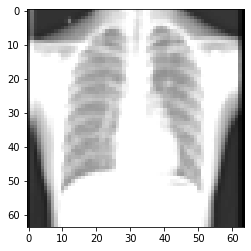

In [62]:
plt.imshow(np.transpose(test_dataset[100][0],axes=(1,2,0)))
print(train_dataset[1600][0].shape)
print(len(train_dataset.classes))
n_classes=len(train_dataset.classes)

In [63]:
print("train",train_dataset.__len__(), len(train_dataset.classes))
print("val",val_dataset.__len__(), len(val_dataset.classes))
print("test",test_dataset.__len__(), len(test_dataset.classes))

train 5882 3
val 27 3
test 635 3


**Data Loader**

In [65]:
# num_workers = 4 if cuda else 0 
    
# Training data
train_loader_args = dict(shuffle=True, batch_size=100, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=800)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=10, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=500)
val_loader = data.DataLoader(val_dataset, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = data.DataLoader(test_dataset, **test_loader_args)


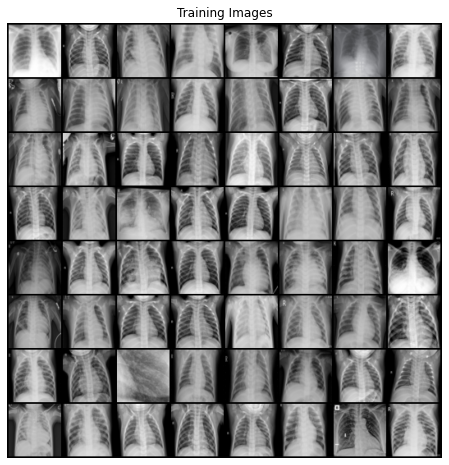

In [66]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**DC GANs Model**

**Weight Initialization**

In [54]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Generator - Model**

In [55]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [57]:
#Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

NameError: ignored